In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..')

In [3]:

import glob
import math

import seaborn
import pandas
from matplotlib import pyplot as plt

from src.experiments.analyze import enrich_results, plot_size_improvement, name_strategies


In [4]:
def read_parquet(pattern, **kwargs):
    frames = []
    for file in glob.glob(pattern):
        part = pandas.read_parquet(file, **kwargs)
        frames.append(part)

    df = pandas.concat(frames)
    return df
    

In [5]:
ref = read_parquet('../output/results/trees_min_samples_leaf_2/*sklearn*')
ref['min_samples_leaf'] = 1
ref['trees'] = 100
ref['dtype'] = 'float'

hyper = read_parquet('../output/results/trees_min_samples_leaf_2/*trees*')
hyper['trees'] = hyper.n_estimators
hyper['dtype'] = 'float'

quant = read_parquet('../output/results/int16/*trees*')
quant['trees'] = quant.n_estimators

data = pandas.concat([ref, hyper, quant], ignore_index=True)
data = enrich_results(data)
#data['total_size_kb'] = data.total_size / 1000
data['leaf_size_percent'] = 100.0 * (data['leaf_size'] / data['total_size'])
data['unique_leaves_percent'] = 100.0 * (data['test_uniqueleaves'] / data['test_leaves'])
data = data[~data.dataset.isin(['1510'])]
data.head(5)

,leaves_per_class,leaf_bits,split,test_nodes,test_leaves,test_leafsize,test_uniqueleaves,test_roc_auc,dataset,experiment,...,train_roc_auc,n_estimators,folds,repetitions,target_max,leaf_size,decision_size,total_size,leaf_size_percent,unique_leaves_percent
id,,,,,,,,,,,,,,,,,,,,,
3d317881-e2c3-45d1-93c2-ac4102ffe988,NaN,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,NaN,NaN,NaN,NaN,NaN,16.0,19968,19984.0,0.080064,0.077042
1fccb1bf-03f8-47f6-821d-d126703d7d54,1.0,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,NaN,NaN,NaN,NaN,NaN,16.0,19968,19984.0,0.080064,0.077042
2575269c-dde0-4261-b035-5dbb6ac78693,2.0,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,NaN,NaN,NaN,NaN,NaN,16.0,19968,19984.0,0.080064,0.077042
1c97c7f1-3575-4115-a89b-1e8f5b26e6b6,4.0,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,NaN,NaN,NaN,NaN,NaN,16.0,19968,19984.0,0.080064,0.077042
8127454c-7976-46cb-afff-61f1c456211f,8.0,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,NaN,NaN,NaN,NaN,NaN,16.0,19968,19984.0,0.080064,0.077042


In [6]:
data.dtype.value_counts()

dtype
float    303450
int16    285600
Name: count, dtype: int64

In [7]:

def compute_perf_change(df, groupby='dataset', metric='test_roc_auc'):
    df = df.copy()

    ref_df = df[df.experiment == 'sklearn_defaults'].reset_index().groupby('dataset').median(numeric_only=True)

    print(sorted(ref_df.index))
    
    # Extract change in performance
    def subtract_ref(df, metric='test_roc_auc'):
        dataset = df.name
        matches = ref_df.loc[dataset]
        #assert len(matches) == 1, matches
        ref = matches[metric]
        out = df[metric] - ref
        return out

    def divide_ref(df, metric='test_roc_auc'):
        dataset = df.name
        matches = ref_df.loc[dataset]
        #assert len(matches) == 1, matches
        ref = matches[metric]
        out = df[metric] / ref
        return out

    grouped = df.groupby('dataset', as_index=False)
    df['perf_change'] = grouped.apply(subtract_ref, include_groups=False).reset_index().set_index('id')[metric]
    df['size_change'] = grouped.apply(divide_ref, metric='total_size', include_groups=False).reset_index().set_index('id')['total_size']

    return df

from src.experiments.analyze import name_strategies

unoptimized = name_strategies(data)
unoptimized = unoptimized[unoptimized.strategy.isin(['original'])]
unoptimized.loc[(unoptimized.experiment == 'sklearn_defaults') & (unoptimized.strategy != 'original')] = None
unoptimized.loc[(unoptimized.strategy == 'joint') & (unoptimized.leaf_bits != 8) & (unoptimized.leaves_per_class != 8), 'strategy'] = None
unoptimized = unoptimized.dropna(subset=['strategy'])
#print(unoptimized[unoptimized.experiment == 'sklearn_defaults']['strategy'].value_counts())
print(unoptimized.experiment.value_counts())
print(unoptimized.strategy.value_counts())
unoptimized = compute_perf_change(unoptimized, groupby=['dataset'])
unoptimized.head(1)

#unoptimized.experiment.value_counts()

experiment
sklearn_defaults                     765
trees_minsamplesleaf_2-40-2          255
trees_minsamplesleaf_2-5-64          255
trees_minsamplesleaf_2-40-64         255
trees_minsamplesleaf_2-10-64         255
                                    ... 
trees_minsamplesleaf_int16-10-16     255
trees_minsamplesleaf_int16-40-128    255
trees_minsamplesleaf_int16-20-8      255
trees_minsamplesleaf_int16-40-2      255
trees_minsamplesleaf_int16-20-32     255
Name: count, Length: 64, dtype: int64
strategy
original    16830
Name: count, dtype: int64
['1049', '1050', '1063', '1067', '1068', '11', '12', '14', '1461', '1462', '1464', '1475', '1480', '1486', '1487', '1489', '1494', '1497', '151', '16', '18', '182', '22', '23', '23517', '28', '3', '307', '31', '32', '37', '40499', '40668', '40670', '40701', '40975', '40979', '40982', '40983', '40984', '40994', '41027', '44', '4534', '4538', '458', '46', '469', '50', '54', '6']


,leaves_per_class,leaf_bits,split,test_nodes,test_leaves,test_leafsize,test_uniqueleaves,test_roc_auc,dataset,experiment,...,repetitions,target_max,leaf_size,decision_size,total_size,leaf_size_percent,unique_leaves_percent,strategy,perf_change,size_change
id,,,,,,,,,,,,,,,,,,,,,
3d317881-e2c3-45d1-93c2-ac4102ffe988,NaN,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,NaN,NaN,16.0,19968,19984.0,0.080064,0.077042,original,0.010785,1.004019


In [8]:
reduced = unoptimized.copy()
reduced = reduced[~reduced.experiment.isin(['sklearn_defaults'])]
reduced.shape

(16065, 27)

/tmp/ipykernel_3572/2595085878.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  g.figure.legend(loc="lower center", ncol=3)


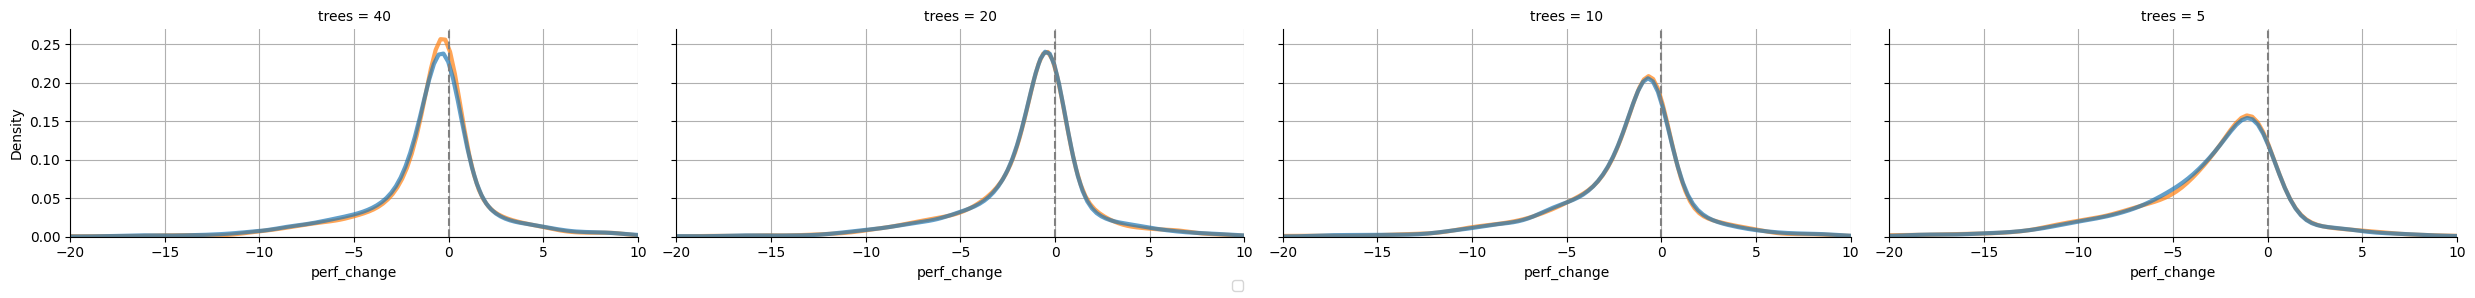

In [9]:


depth_limit = 'min_samples_leaf'
sel = reduced.copy()
#sel = sel[sel.trees == 10]
col_order = sorted(sel.trees.unique(), reverse=True)
g = seaborn.displot(data=sel.reset_index(),
                    kind='kde',
                    #x=depth_limit,
                    x='perf_change',
                    hue='dtype',
                    col='trees',
                    col_order=col_order,
                    aspect=2, height=3,
                    common_norm=False,
                    lw=3.0,
                    alpha=0.7,
                   )
g.refline(x=0.0)
g.set(xlim=(-20, 10))
for ax in g.axes.flatten():
    ax.grid()  
g.figure.tight_layout()
g.figure.legends = []
g.figure.legend(loc="lower center", ncol=3)
g.figure.savefig('int16-vs-float.png')
